# Ensemble Experiments

Code to answer the following question(s):

1. Do safe base learners imply safe ensembles?
1. Do safe ensembles imply safe base learners?

The question is answered via comparing results from Decision Trees with those from Random Forests where the key hyper-parameters (`min_samples_split`, `min_samples_leaf`, `max_depth`) are the same. I.e. we therefore have the comparison of the base learner and the ensemble, where the hyper-parameters match. The results show that you _can_ get more risky ensembles than base learners in this case.

To further investigate, one of the worst examples (decision tree mia AUC = 0.5, RF AUC = 0.9) was extracted and trained. The attack metrics were computed. Then each individual tree was assessed. All of the individual trees are safe but the ensemble clearly isn't.

Need some more work to see if an unsafe base learner can exist within an ensemble that appears safe.

In [76]:
from data_preprocessing.data_interface import get_data_sklearn
import logging
import pandas as pd
import numpy as np

logging.basicConfig(level = logging.INFO)

import pylab as plt
%matplotlib inline
logging.basicConfig(level=logging.INFO)
font = {'size': 18}
plt.rc('font', **font)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


Load the D-tree and RandomForest results. We only keep the non-bootstrap results as these are the most risky.

In [43]:
# Load dtree results
dtr = pd.read_csv("results/from_aws/DecisionTreeClassifier_results_corrected.csv")
rfr = pd.read_csv("results/from_aws/RandomForest_results_corrected.csv")
rfr = rfr[rfr['bootstrap'] == False]
all_res = pd.concat((dtr, rfr), ignore_index=True)

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


Plot decision tree versus random forest where each point is the same hyper-parameters. This allows us to quickly see if there are hyper-param sets that produce safe trees, but unsafe forests.

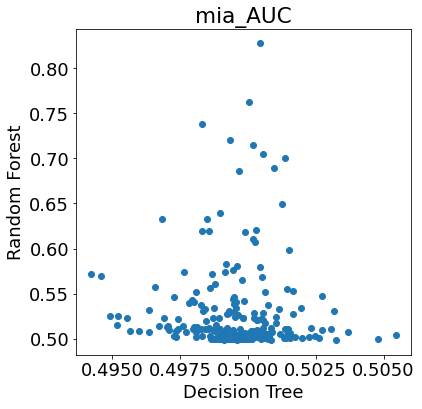

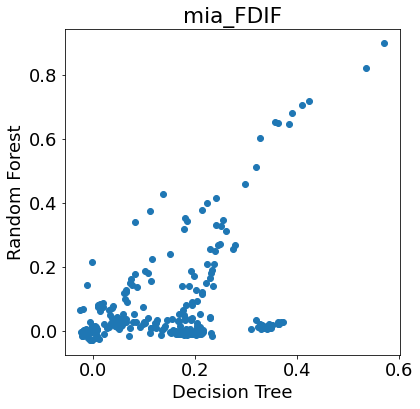

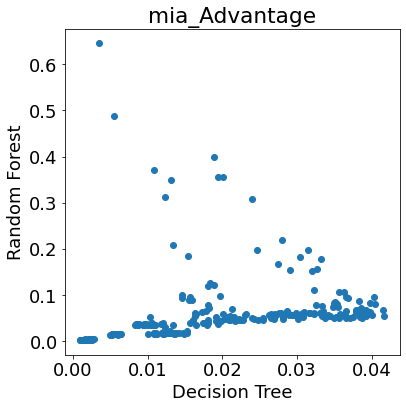

In [78]:
metrics_to_plot = [
    'mia_AUC',
    'mia_FDIF',
    'mia_Advantage'
]
for metric in metrics_to_plot:
    group_pars = [
        'target_classifier',
        'dataset',
        'min_samples_split',
        'min_samples_leaf',
        'max_depth'
    ]
    # Average the chosen metric over all things except target_classifier, dataset, and the three relevant hyper-pars
    tt = all_res.groupby(group_pars).aggregate(mean_metric=(metric, np.mean))
    tt.reset_index(inplace=True)
    
    # Pivot by the same columns, without target_classifier. This will pivot into a dataframe with
    # one column for D-tree and one for RF with rows with matching values
    pivot_index = group_pars[1:]
    ptt = tt.pivot(index=pivot_index, columns="target_classifier", values="mean_metric")
    ptt.reset_index(inplace=True)

    # Plot for this metric and save
    plt.figure(figsize=(6, 6))
    plt.scatter(ptt['DecisionTreeClassifier'], ptt['RandomForestClassifier'])
    plt.xlabel('Decision Tree')
    plt.ylabel('Random Forest')
    plt.title(metric)
    plt.savefig(f'ensemble_{metric}.png')

Now look in more detail at some specific examples - in particular the example that has mia AUC over 0.8.

Same pivoting as above, but just for mia_AUC

In [79]:
metric = 'mia_AUC'
tt = all_res.groupby(group_pars).aggregate(mean_metric=(metric, np.mean))
tt.reset_index(inplace=True)
pivot_index = group_pars[1:] # skip target class
ptt = tt.pivot(index=pivot_index, columns="target_classifier", values="mean_metric")
ptt.reset_index(inplace=True)
ptt['metric_diff'] = ptt['RandomForestClassifier'] - ptt['DecisionTreeClassifier']
ptt_sub = ptt[(ptt['RandomForestClassifier'] > 0.8)]
print(ptt_sub.head())

target_classifier                dataset  min_samples_split  min_samples_leaf  \
2                  in-hospital-mortality                  2                 1   

target_classifier  max_depth  DecisionTreeClassifier  RandomForestClassifier  \
2                       10.0                0.500465                0.827144   

target_classifier  metric_diff  
2                     0.326679  


Using the hyper-params identified above, train the random forest and simulate a (worst case) attack

In [84]:
min_samples_split = 2
min_samples_leaf = 1
max_depth = 10.0
X, y= get_data_sklearn('in-hospital-mortality')
from attacks.scenarios import split_target_data, worst_case_mia
from attacks.metrics import get_metrics
from sklearn.ensemble import RandomForestClassifier
X_target, X_train, X_test, y_target, y_train, y_test = split_target_data(X.values, y.values.flatten())
rf = RandomForestClassifier(
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_depth=10,
    bootstrap=False
)
rf.fit(X_target, y_target)
mia_test_probs, mia_test_labels, mia_classifier = worst_case_mia(rf, X_target, X_test)
rf_metrics = get_metrics(mia_classifier, mia_test_probs, mia_test_labels)
metrics = [m.split('_')[1] for m in metrics_to_plot]
for m in metrics:
    print(sub_m, rf_metrics[m])


INFO:c:\Users\simonr04\git\GRAIMatter\data_preprocessing\data_interface.py:DATASET FOLDER = c:\Users\simonr04\git\GRAIMatter\data


Advantage 0.97752472
Advantage 1.0
Advantage 0.9433623


Assess the base learners for the same metrics. They are accessible in the `estimators_` class attribute

In [85]:
base_learner_metrics = {m: [] for m in metrics}
for i, base_learner in enumerate(rf.estimators_):
    if i % 10 == 0:
        print(i)
    mia_test_probs, mia_test_labels, mia_classifier = worst_case_mia(base_learner, X_target, X_test)
    e_metrics = get_metrics(mia_classifier, mia_test_probs, mia_test_labels)
    for m in metrics:
        base_learner_metrics[m].append(e_metrics[m])

0
10
20
30
40
50
60
70
80
90


Plot histograms of the metrics, showing the ensemble value as a dashed line.

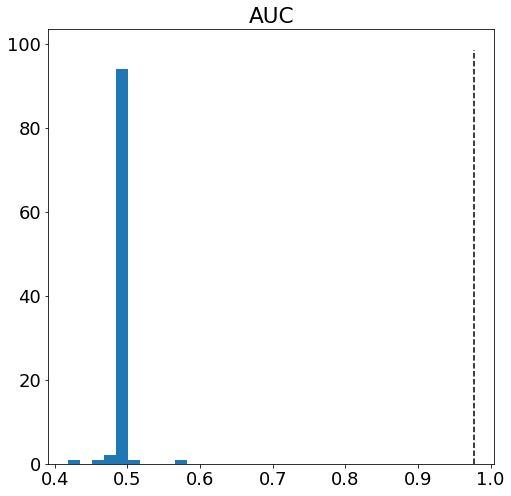

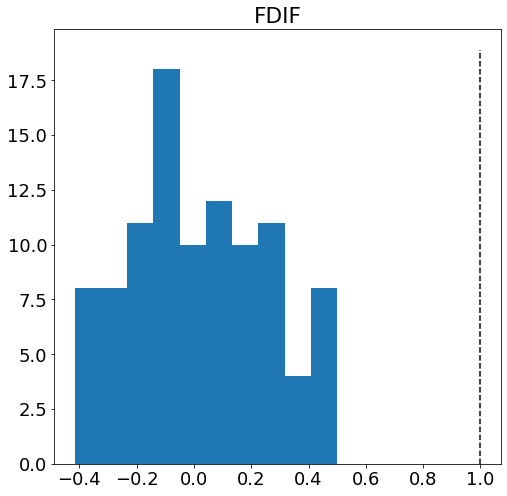

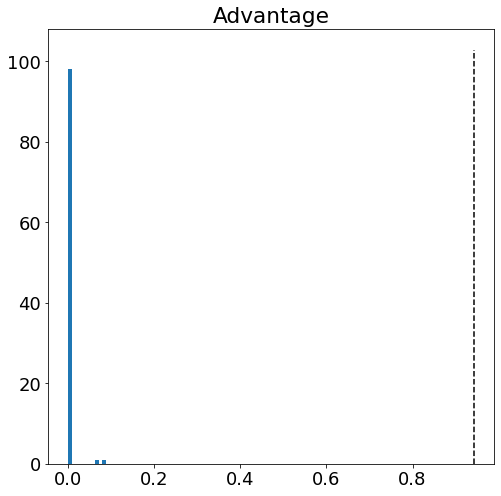

In [87]:
for m in metrics:
    plt.figure(figsize=(8, 8))
    plt.hist(base_learner_metrics[m])
    plt.title(m)
    yl = plt.ylim()
    plt.plot([rf_metrics[m], rf_metrics[m]], yl, 'k--')
    plt.savefig(f'base_hist_{metric}.png')